## Beep making
### exercise 4: ADDITIVE RESYNTHESIS
### (LIGO data example)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# from the y21 notebook-- do we need these?
from subprocess import Popen
import subprocess as sp
import os

import pandas as pd

import pywt
import resampy as rp

import IPython.display as ipd

from funcs import bips as bip
from funcs import notepicker


In [2]:
# READ IN THE DATA FILE 
print(os.listdir(os.path.abspath('./data/LIGO/')))
 
datafilename = './data/LIGO/obs_LivingstonLA.txt'      

data = np.loadtxt(datafilename)
print(np.shape(data))
x = data[:, 0]
x = x - x[0]  # make time start at zero
y = data[:, 1]  

['obs_LivingstonLA.txt', '.ipynb_checkpoints', 'obs_HanfordWA.txt']
(3441, 2)


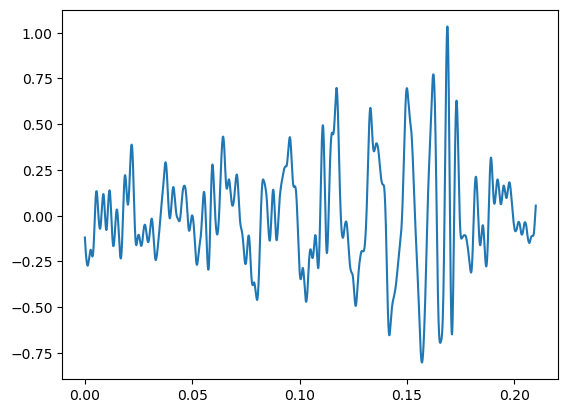

In [3]:
plt.plot(x,y)

In [4]:
# direct sonification of the chirp signal, 
# sampled at the rate of the original data: 
ipd.Audio(y, rate=int(fs)) 

NameError: name 'fs' is not defined

original sampling frequency = 16384.0


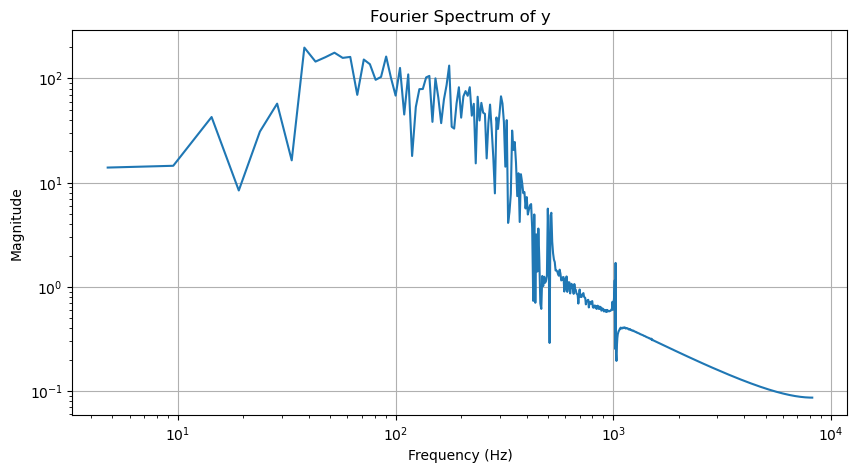

In [115]:
# Plot the Fourier spectrum (magnitude) of the entire signal y

# Compute the FFT
Y = np.fft.fft(y)
N = len(y)
fs = 1/(x[1] - x[0])  # Sampling frequency
print(f'original sampling frequency = {fs}')
freqs = np.fft.fftfreq(N, d=(x[1] - x[0]))

# Only keep the positive frequencies
idx = np.where(freqs > 0)

plt.figure(figsize=(10, 5))
plt.plot(freqs[idx], np.abs(Y[idx]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum of y')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

In [149]:
# Wavelet transform and periodogram plot for y using PyWavelets

# Choose a wavelet and scales
wavelet = 'cmor1.5-1.0'  # Complex Morlet, good for time-frequency
scales = np.arange(5, 256)
#scales = np.arange(100, 2*256)

# Perform the continuous wavelet transform (CWT)
coefficients, frequencies = pywt.cwt(y, scales, wavelet, sampling_period=(x[1]-x[0]))
periods = 1/frequencies

# Compute the periodogram (power spectrum)
power = (np.abs(coefficients) ** 2).mean(axis=1)

# Plot the wavelet scalogram (time-frequency representation) using PyWavelets

# coefficients, frequencies already computed above
scalomat = np.abs(coefficients)


(251, 3441)


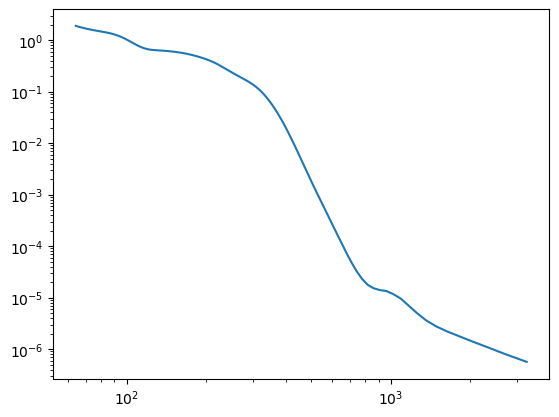

In [186]:
#print(periods)
print(np.shape(scalomat))
plt.loglog(frequencies,power)

In [210]:

freqs4oscbank = np.linspace(4,20,6)*100  # seconds
print(freqs4oscbank)

[ 400.  720. 1040. 1360. 1680. 2000.]


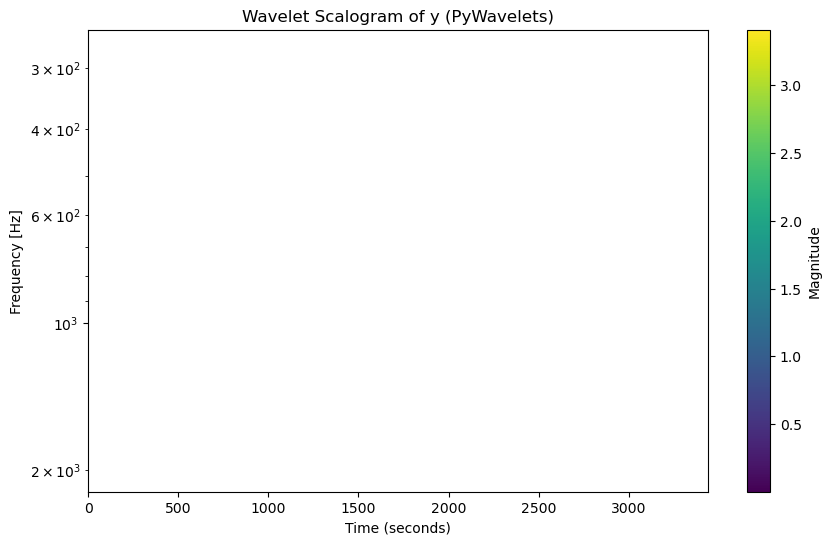

In [218]:
# plot using meshgrid with time and frequency. 
# then overlay the perds4oscbank lines. 

# plot the scalogram. 
plt.figure(figsize=(10, 6))
plt.imshow(
    scalomat,
    aspect='auto',
    #extent=[x[0], x[-1], periods[-1], periods[0]],  # periods[-1] is min, periods[0] is max
    #extent=[x[0], x[-1], frequencies[-1], frequencies[0]],  # periods[-1] is min, periods[0] is max
    cmap='viridis',
    origin='upper'
)

plt.hlines(freqs4oscbank,x[0], x[-1],color='tab:red')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency [Hz]')
plt.title('Wavelet Scalogram of y (PyWavelets)')
plt.yscale('log')
plt.show()

In [212]:
# Find the indexes of the nearest values in 'periods' for each value in 'perds4oscbank'
nearest_idxs = [np.abs(frequencies - val).argmin() for val in freqs4oscbank]
selected_freqs = frequencies[nearest_idxs]
print('Indexes of nearest frequencies:', nearest_idxs)
print('Nearest frequency values:', selected_freqs)
#print('Frequencies:', frequencies)

Indexes of nearest frequencies: [36, 18, 11, 7, 5, 3]
Nearest frequency values: [ 399.6097561   712.34782609 1024.         1365.33333333 1638.4
 2048.        ]


(6, 3441)
Selected frequency: 399.609756 Hz at index 36
Selected frequency: 712.347826 Hz at index 18
Selected frequency: 1024.000000 Hz at index 11
Selected frequency: 1365.333333 Hz at index 7
Selected frequency: 1638.400000 Hz at index 5
Selected frequency: 2048.000000 Hz at index 3


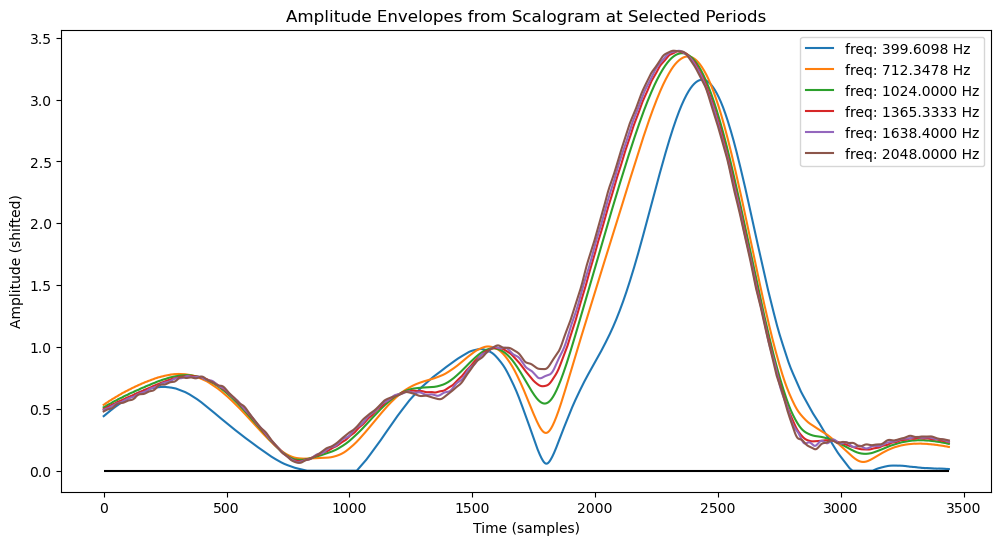

In [217]:
shift = 0.0
env_amp_mat = np.zeros((len(nearest_idxs), len(scalomat[0,:])))
print(np.shape(env_amp_mat))
for i,idx in enumerate(nearest_idxs):
    print(f"Selected frequency: {frequencies[idx]:.6f} Hz at index {idx}")
    # Needed -idx because the scalogram is ordered by period (high to low frequency)! 
    env_amp_mat[i,:]= scalomat[-idx,:]-np.mean(scalomat[idx,:])+shift
# remove any values less than zero:
env_amp_mat[env_amp_mat < 0] = 0

plt.figure(figsize=(12, 6))
for i in range(env_amp_mat.shape[0]):
    #plt.plot(env_amp_mat[i, :], label=f'Period: {periods[nearest_idxs[i]]:.6f} s')
    plt.plot(env_amp_mat[i, :], label=f'freq: {1/periods[nearest_idxs[i]]:.4f} Hz')
plt.hlines(0, 0, env_amp_mat.shape[1], colors='black')
plt.title('Amplitude Envelopes from Scalogram at Selected Periods')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (shifted)')
plt.legend()
plt.show()

In [214]:
# now resample the envelopes to audio rate and use them to modulate sine wave oscillators
sr_audio = 44100  # audio sample rate
dur = 6  # duration, seconds
num_samples = int(sr_audio * dur)
time_rs = np.linspace(0, x[-1] , num_samples)
env_amp_mat_rs = np.zeros((env_amp_mat.shape[0], num_samples))
print(np.shape(env_amp_mat_rs))

sr_orig = 1/(x[1]-x[0])  # original sample rate of data
for i in range(env_amp_mat.shape[0]):
    env_amp_mat_rs[i, :] = np.interp(time_rs, x, env_amp_mat[i, :])
    #env_amp_mat_rs[i, :] = rp.resample(env_amp_mat[i, :], fs, 44100) 
# y_low = resampy.resample(x, sr_orig, 16000)
# call the bip function to make the oscillators and mix them down

(6, 264600)


In [ ]:

b = bip.Beep()
b.make_bip(dur, freqs, env_amp_mat_rs)
wf = b.wf/(np.max(np.abs(b.wf))) # normalize
# taper the waveform: 
wf = bip.taper_waveform(wf, alpha=0.05)



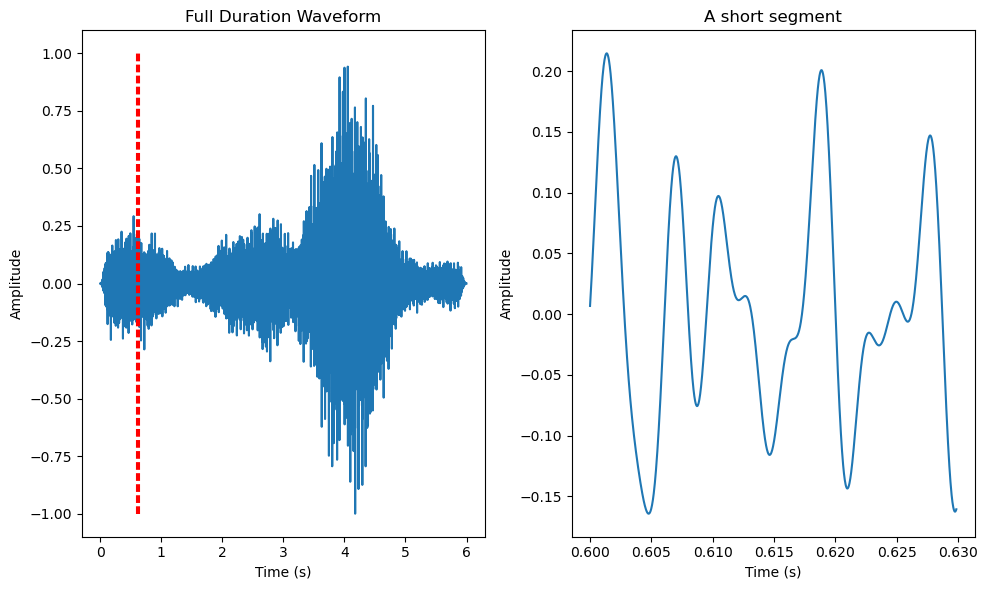

In [216]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot a few oscillations first, then the whole waveform
start = int(0.1*len(wf))
end = start + int(10*(1/freqs[0])*44100)  # First 4 cycles (samples)
t_short = b.t_vec[start:end]  # First 100 samples
wf_short = wf[start:end]

# call the function with the existing variables
bip.plot_waveforms(ax1, ax2, t_short, wf_short, b.t_vec, wf)
plt.tight_layout()
plt.show()

ipd.Audio(wf, rate=sr_audio)